In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('Surgery.csv',delimiter = ";")
scoring_data = pd.read_csv('Surgery_scoring.csv',delimiter = ";")

# Not null and na found at all
if data.isnull().sum().any() or scoring_data.isnull().sum().any() or data.isna().sum().any() or scoring_data.isna().sum().any():
    print("There are null or NaN values in the data.")
else:
    print("Not null and na found at all in this case")
 

Not null and na found at all in this case


In [3]:
# Prétraitement des données
X = data.drop(columns=['PatientID', 'complication'])
y = data['complication']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Méthode 1 : Régression logistique
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_val)

precision_0_log = precision_score(y_val, y_pred_log, pos_label=0)
precision_1_log = precision_score(y_val, y_pred_log, pos_label=1)
cost_function_log = 0.5 * precision_0_log + 0.5 * precision_1_log
print(f'Regression logistique - Cost function: {cost_function_log}')

# Méthode 2 : ACP + Régression logistique # Pipeline combinant PCA et Régression logistique
pipeline_acp = Pipeline([
    ('pca', PCA(n_components=0.95)),  # Conserver 95% de la variance
    ('log_reg', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_acp.fit(X_train, y_train)

y_pred_acp = pipeline_acp.predict(X_val)
precision_0_acp = precision_score(y_val, y_pred_acp, pos_label=0)
precision_1_acp = precision_score(y_val, y_pred_acp, pos_label=1)
cost_function_acp = 0.5 * precision_0_acp + 0.5 * precision_1_acp
print(f'ACP + Régression logistique - Cost function: {cost_function_acp}')

# Méthode 3 : Arbre de décision
ad = DecisionTreeClassifier(random_state=42)
param_grid_ad = {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_search_ad = GridSearchCV(estimator=ad, param_grid=param_grid_ad, cv=5, n_jobs=-1)
grid_search_ad.fit(X_train, y_train)

y_pred_ad = grid_search_ad.best_estimator_.predict(X_val)
precision_0_ad = precision_score(y_val, y_pred_ad, pos_label=0)
precision_1_ad = precision_score(y_val, y_pred_ad, pos_label=1)
cost_function_ad = 0.5 * precision_0_ad + 0.5 * precision_1_ad
print(f'Arbre de décision - Cost function: {cost_function_ad}')

# Méthode 4 : Forêt aléatoire
fa = RandomForestClassifier(random_state=42)
param_grid_fa = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_search_fa = GridSearchCV(estimator=fa, param_grid=param_grid_fa, cv=5, n_jobs=-1)
grid_search_fa.fit(X_train, y_train)

y_pred_fa = grid_search_fa.best_estimator_.predict(X_val)
precision_0_fa = precision_score(y_val, y_pred_fa, pos_label=0)
precision_1_fa = precision_score(y_val, y_pred_fa, pos_label=1)
cost_function_fa = 0.5 * precision_0_fa + 0.5 * precision_1_fa
print(f'Forêt aléatoire - Cost function: {cost_function_fa}')



Regression logistique - Cost function: 0.754764035623854
ACP + Régression logistique - Cost function: 0.7526388200736127
Arbre de décision - Cost function: 0.8866339133361966
Forêt aléatoire - Cost function: 0.8612473981408941


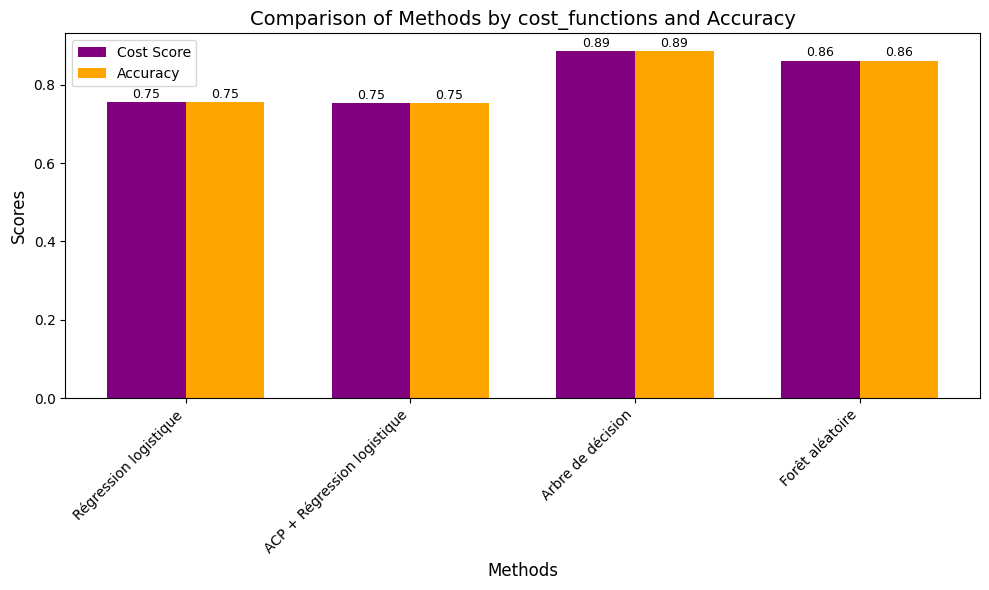

In [4]:
methods = ['Régression logistique', 'ACP + Régression logistique','Arbre de décision', 'Forêt aléatoire']
cost_functions = [cost_function_log, cost_function_acp, cost_function_ad, cost_function_fa]
accuracies = [
    (precision_0_log + precision_1_log) / 2, 
    (precision_0_acp + precision_1_acp) / 2,   
    (precision_0_ad + precision_1_ad) / 2,   
    (precision_0_fa + precision_1_fa) / 2  # Average precision 
]

# Create bar plot
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, cost_functions, width, label='Cost Score', color='purple')
bars2 = ax.bar(x + width/2, accuracies, width, label='Accuracy', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Methods by cost_functions and Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [5]:
# Sélection du meilleur modèle
best_model = max(
    [('Régression logistique', cost_function_log, log_reg),
     ('ACP + Régression logistique', cost_function_acp, log_reg),
     ('Arbre de décision', cost_function_ad, grid_search_ad.best_estimator_),
     ('Forêt aléatoire', cost_function_fa, grid_search_fa.best_estimator_)],
    key=lambda x: x[1]
)
print(f"Meilleur modèle : {best_model[0]} avec un score {best_model[2]}")

# Prédictions sur la base de scoring
X_scoring = scoring_data.drop(columns=['PatientID'])
X_scoring_scaled = scaler.transform(X_scoring)

y_scoring_pred = best_model[2].predict(X_scoring_scaled)

# Export des prédictions
predictions = pd.DataFrame({
    'PatientID': scoring_data['PatientID'],
    'classe': y_scoring_pred
})

predictions

Meilleur modèle : Arbre de décision avec un score DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)


,PatientID,classe
0,10110,0
1,10111,0
2,10112,0
3,10113,1
4,10114,1
...,...,...
4521,14631,1
4522,14632,1
4523,14633,1
4524,14634,1


In [6]:
predictions.to_csv('Surgey_scoring_predictions_JIANG_Qizhen.csv', index=False, columns=['PatientID', 'classe'], sep=';')